<a href="https://colab.research.google.com/github/Simi912/Deep-convolutional-neural-network-classifier-for-Alzheimer-s-Disease-1/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DECLARE VARIABLES

In [ ]:
import pickle
import pathlib
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
import os
import cv2
import PIL
import glob
from tensorflow import keras
from keras.models import Sequential, load_model
from tensorflow.keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, Rescaling, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, auc

from sklearn.model_selection import train_test_split


# DOWNLOAD DATA

In [ ]:
# access google drive for creating a folder
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


*****Make sure to rename the folder after it has downloaded to "ISIC DATA"****

# Load Data

In [ ]:
# Defining the path for train and test images
import pathlib
data_dir_train = pathlib.Path("/content/drive/MyDrive/16 07/MTL-GAMMA copy")


In [ ]:
#visualize images loaded from google drive

img_data = []
label = []

IMG_HEIGHT = 180
IMG_WIDTH = 180

for i in os.listdir(data_dir_train):
    impath = os.path.join(data_dir_train,i)
    im = glob.glob(impath + '/*.png')
    print(len(im))
    for j in im:
        img= cv2.imread(j)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        img=np.array(img)
        img = img.astype('float32')
        img_data.append(img)
        label.append(i)

2700
2820
0


In [ ]:
len(img_data)

5520

In [ ]:
len(label)

5520

In [ ]:
vals, ids, y = np.unique(label, return_index=True, return_inverse=True)
print(vals)
print(y)

['MTL AD-GAMMA' 'MTL-MCI']
[0 0 0 ... 1 1 1]


# visualization

1793
1996
394
3421
1767
1250
2234
1212
787


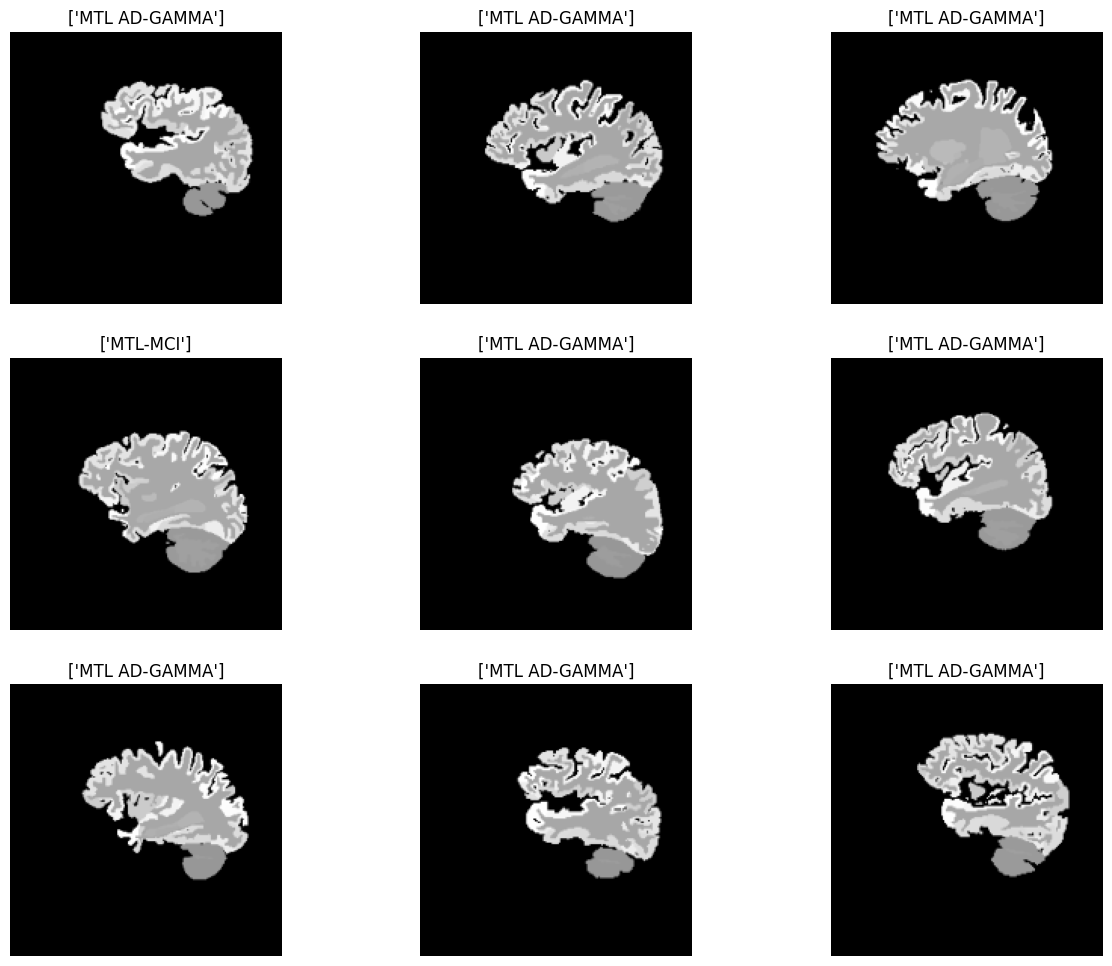

In [ ]:
# visualize images loaded with the keras utility (image_dataset_from_directory)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(9):
    num=random.randint(0,4120)
    print(num)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_data[num].astype("uint8"), cmap= "gray")
    plt.title([label[num]])
    plt.axis("off")

# Data Split

In [ ]:
#Split dataset into 80% training 20% others
X_train, X_others, y_train, y_others = train_test_split(img_data, y, test_size=0.2, random_state=0, stratify=y)
#Split dataset into 50% training 50% testing
X_valid, X_test, y_valid, y_test = train_test_split(X_others, y_others, test_size=0.5, random_state=0, stratify=y_others)


In [ ]:
#reshaping for cnn
# defining the sets of train and test
X_train = np.array(X_train).reshape(-1, 180,180, 1)
X_valid = np.array(X_valid).reshape(-1, 180, 180, 1)
X_test = np.array(X_test).reshape(-1, 180, 180, 1)
X_train /= 255
X_valid/=255
X_test /= 255

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(4416, 180, 180, 1)
(552, 180, 180, 1)
(552, 180, 180, 1)
(4416,)
(552,)
(552,)


In [ ]:
np.unique(y_train)

array([0, 1])

# DEEP CNN

Using MaxPooling and Dropout!

In [ ]:
num_classes = 2
input_shape = X_train[0].shape

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation ='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 89, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 123904)            0

In [ ]:
# compiling the model
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss', # monitor validation loss
    patience=5, # number of epochs with no improvement before stopping
    restore_best_weights=True) # restore the best weights when stopping

In [ ]:
# Define model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'MTL1.h5', # file to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # save only the best model
)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100,validation_data=(X_valid, y_valid), callbacks=[early_stopping, checkpoint])

Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 3.1124 - accuracy: 0.6159

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 28s 146ms/step - loss: 3.1124 - accuracy: 0.6159 - val_loss: 1.3180 - val_accuracy: 0.6739
Epoch 2/100
138/138 [==============================] - 15s 108ms/step - loss: 1.1751 - accuracy: 0.6449 - val_loss: 1.0467 - val_accuracy: 0.6866
Epoch 3/100
138/138 [==============================] - 11s 77ms/step - loss: 0.9831 - accuracy: 0.6476 - val_loss: 0.9091 - val_accuracy: 0.7101
Epoch 4/100
138/138 [==============================] - 11s 79ms/step - loss: 0.8742 - accuracy: 0.6671 - val_loss: 0.8127 - val_accuracy: 0.6975
Epoch 5/100
138/138 [==============================] - 18s 133ms/step - loss: 0.8045 - accuracy: 0.6852 - val_loss: 0.7842 - val_accuracy: 0.6902
Epoch 6/100
138/138 [==============================] - 19s 137ms/step - loss: 0.7536 - accuracy: 0.6916 - val_loss: 0.7160 - val_accuracy: 0.7047
Epoch 7/100
138/138 [==============================] - 21s 150ms/step - loss: 0.7190 - accuracy: 0.7040 - val_loss: 0.6856 - val_accuracy:

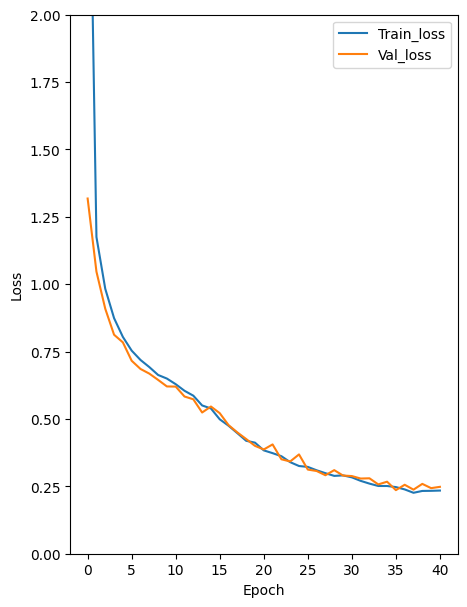

In [ ]:
plt.rcParams["figure.figsize"] = (5,7)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


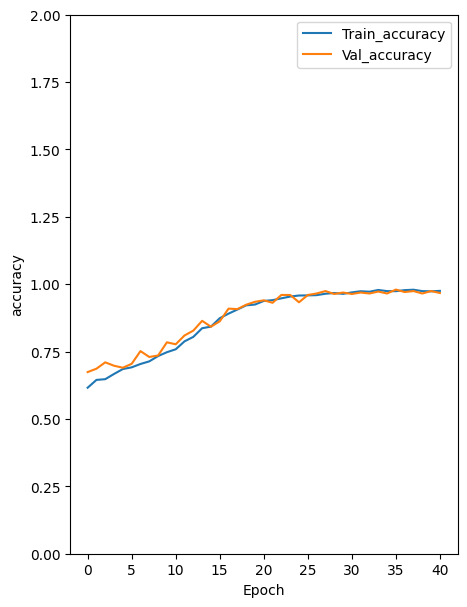

In [ ]:
plt.rcParams["figure.figsize"] = (5,7)
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Val_accuracy')
plt.ylim([0, 2])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
file_path = '/content/drive/MyDrive/Models/MTL1.h5'
model.save(file_path)

In [ ]:
print(model.input_shape)

(None, 180, 180, 1)


In [ ]:
model = load_model('MTL1.h5')
y_pred = np.argmax(model.predict(X_test), axis=-1)

18/18 [==============================] - 0s 11ms/step


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_mat.ravel()
specificity = tn / (tn + fp)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUROC:", auroc)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 0.9710144927536232
Precision: 0.9683098591549296
Recall: 0.975177304964539
F1 Score: 0.9717314487632509
AUROC: 0.9709219858156027
Specificity: 0.9666666666666667


NameError: name 'sensitivity' is not defined

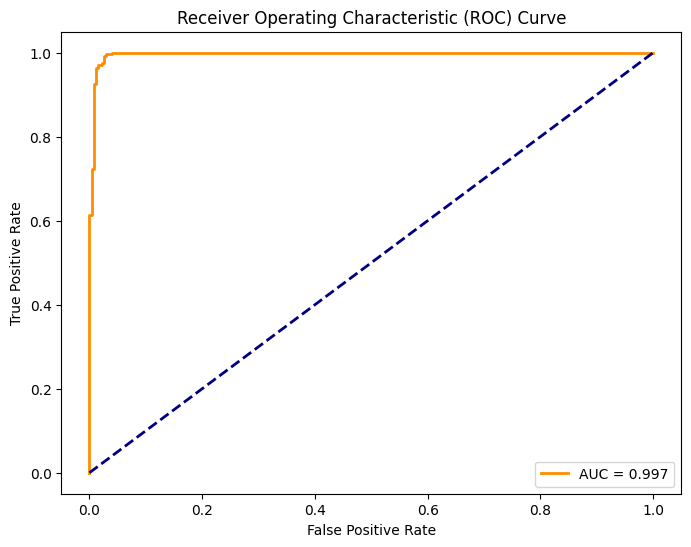

In [ ]:
plt.figure(figsize=(8, 6))
plt.step(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Assuming y_pred and y_true are available

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP = np.sum((y_pred == 1) & (y_test == 1))
FP = np.sum((y_pred == 1) & (y_test == 0))
TN = np.sum((y_pred == 0) & (y_test == 0))
FN = np.sum((y_pred == 0) & (y_test == 1))

# Calculate Sensitivity (True Positive Rate) and Specificity (True Negative Rate)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)


In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming y_true are the true labels and y_pred are the predicted labels
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)


In [ ]:
print(sensitivity)

0.9858156028368794


In [ ]:
print(specificity)

0.9703703703703703
